<div style="text-align:center">
    <h1>
        REINFORCE
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to implement the Monte Carlo version of Policy Gradient methods. The REINFORCE algorithm uses the full return to update the policy:
</div>

\begin{equation}
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+1} + \cdots + \gamma^{T-t-1} R_{T}
\end{equation}



<br>

## Import the necessary software libraries:

In [1]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_learning_curve(scores, x, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class PolicyGradientAgent():
    def __init__(self, lr, input_dims, gamma=0.99, n_actions=4):
        self.gamma = gamma
        self.lr = lr
        self.reward_memory = []
        self.action_memory = []

        self.policy = PolicyNetwork(self.lr, input_dims, n_actions)

    def choose_action(self, observation):
        state = T.Tensor([observation]).to(self.policy.device)
        probabilities = F.softmax(self.policy.forward(state))
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_memory.append(log_probs)

        return action.item()

    def store_rewards(self, reward):
        self.reward_memory.append(reward)

    def learn(self):
        self.policy.optimizer.zero_grad()

        # G_t = R_t+1 + gamma * R_t+2 + gamma**2 * R_t+3
        # G_t = sum from k=0 to k=T {gamma**k * R_t+k+1}
        G = np.zeros_like(self.reward_memory, dtype=np.float64)
        for t in range(len(self.reward_memory)):
            G_sum = 0
            discount = 1
            for k in range(t, len(self.reward_memory)):
                G_sum += self.reward_memory[k] * discount
                discount *= self.gamma
            G[t] = G_sum
        G = T.tensor(G, dtype=T.float).to(self.policy.device)
        
        loss = 0
        for g, logprob in zip(G, self.action_memory):
            loss += -g * logprob
        loss.backward()
        self.policy.optimizer.step()

        self.action_memory = []
        self.reward_memory = []

/tmp/ipykernel_758607/677342983.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  state = T.Tensor([observation]).to(self.policy.device)
/tmp/ipykernel_758607/677342983.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(self.policy.forward(state))


episode  0 score -237.42 average score -237.42
episode  1 score -600.80 average score -419.11
episode  2 score -114.37 average score -317.53
episode  3 score -97.66 average score -262.56
episode  4 score -161.15 average score -242.28
episode  5 score -58.22 average score -211.60
episode  6 score -114.76 average score -197.77
episode  7 score -288.21 average score -209.07
episode  8 score -172.23 average score -204.98
episode  9 score -196.54 average score -204.14
episode  10 score -92.51 average score -193.99
episode  11 score -149.81 average score -190.31
episode  12 score -115.71 average score -184.57
episode  13 score -200.74 average score -185.72
episode  14 score 3.07 average score -173.14
episode  15 score -378.14 average score -185.95
episode  16 score -101.11 average score -180.96
episode  17 score -262.08 average score -185.47
episode  18 score -299.36 average score -191.46
episode  19 score -118.32 average score -187.80
episode  20 score -181.70 average score -187.51
episode 

FileNotFoundError: [Errno 2] No such file or directory: 'plots/REINFORCE_lunar_lunar_lr0.0005_3000games.png'

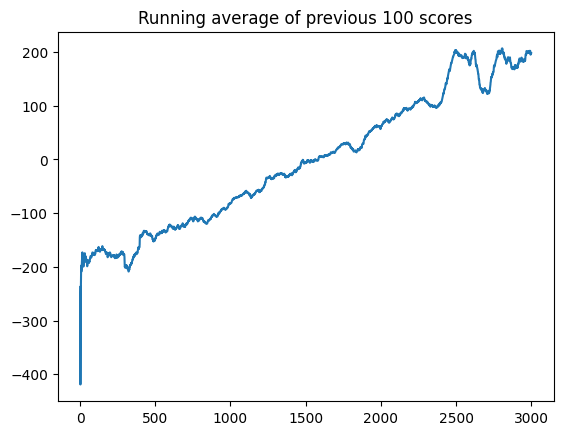

In [4]:
if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    n_games = 3000
    agent = PolicyGradientAgent(gamma=0.99, lr=0.0005, input_dims=[8],
                                n_actions=4)

    fname = 'REINFORCE_' + 'lunar_lunar_lr' + str(agent.lr) + '_' \
            + str(n_games) + 'games'
    figure_file = 'plots/' + fname + '.png'

    scores = []
    for i in range(n_games):
        done = False
        observation = env.reset()
        score = 0
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_rewards(reward)
            observation = observation_
        agent.learn()
        scores.append(score)

        avg_score = np.mean(scores[-100:])
        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score)

    x = [i+1 for i in range(len(scores))]
    plot_learning_curve(scores, x, figure_file)